# Homework 3


## References

+ Lectures 7-12 (inclusive).

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os
import math

from matplotlib import rc
rc('text', usetex=True)

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name:** Jack
+ **Last Name:** Girard
+ **Email:** girard2@purdue.edu

## Problem 1 - Propagating uncertainty through a differential equation 

This is a classic uncertainty propagation problem that you will have to solve using Monte Carlo sampling.
Consider the following stochastic harmonic oscillator:

$$
\begin{array}{ccc}
\ddot{y} + 2 \zeta \omega(X) \dot{y} + \omega^2(X)y &=& 0,\\
y(0) &=& y_0(X),\\
\dot{y}(0) &=& v_0(X),
\end{array}
$$

where:
+ $X = (X_1, X_2, X_3)$,
+ $X_i \sim N(0, 1)$,
+ $\omega(X) = 2\pi + X_1$, 
+ $\zeta = 0.01$,
+ $y_0(X) = 1+ 0.1 X_2$, and
+ $v_0 = 0.1 X_3$.

In words, this stochastic harmonic oscillator has an uncertain natural frequency and uncertain initial conditions.

Our goal is to propagate uncertainty through this dynamical system, i.e., estimate the mean and variance of its solution.
A solver for this dynamical system is given below:

In [2]:
class Solver(object):
    def __init__(
        self,
        nt=100,
        T= 5
    ):
        """This is the initializer of the class.
        
        Arguments:
            nt -- The number of timesteps.
            T  -- The final time.
        """
        self.nt = nt
        self.T = T
        # The timesteps on which we will get the solution
        self.t = np.linspace(0, T, nt) 
        # The number of inputs the class accepts
        self.num_input = 3
        # The number of outputs the class returns
        self.num_output = nt
        
    def __call__(self, x):
        """This special class method emulates a function call.
        
        Arguments:
            x -- A 1D numpy array with 3 elements.
                 This represents the stochastic input x = (x1, x2, x3).
        
        Returns the solution to the differential equation evaluated
        at discrete timesteps.
        """
        # uncertain quantities 
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        
        # ODE parameters 
        omega = 2*np.pi + x1 
        y10 = 1 + 0.1*x2
        y20 = 0.1*x3
        # initial conditions 
        y0 = np.array([y10, y20])   
        
        # coefficient matrix 
        zeta = 0.01
        # spring constant
        k = omega**2
        # damping coeff
        c = 2*zeta*omega    
        C = np.array([[0, 1],[-k, -c]])
        
        #RHS of the ODE system
        def rhs(y, t):
            return np.dot(C, y)
        
        y = scipy.integrate.odeint(rhs, y0, self.t)
        
        return y

First, let's demonstrate how the solver works:

In [3]:
solver = Solver()
 
x = np.random.randn(solver.num_input)

y = solver(x)

#print(y)

Notice the dimension of `y`:

In [4]:
print("Shape of y: ", y.shape)

Shape of y:  (100, 2)


The 100 rows corresponds to timesteps.
The 2 columns correspond to position and velocity.

Let's plot a few samples:

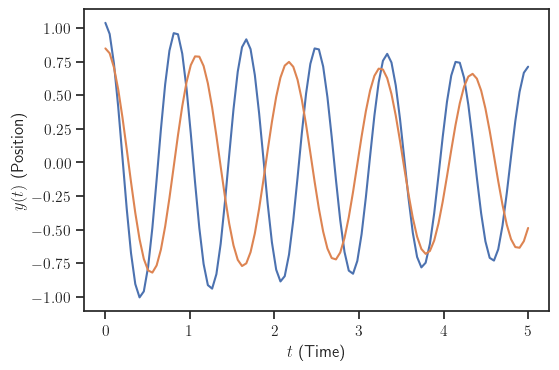

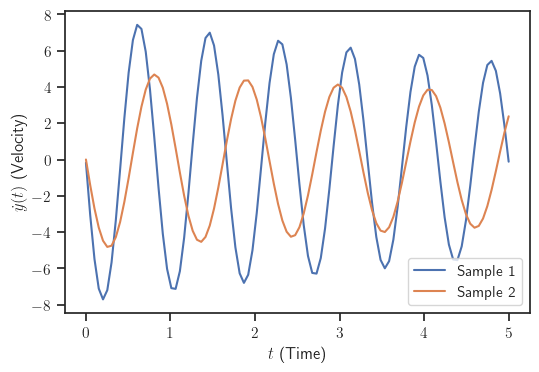

In [5]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('$t$ (Time)')
ax1.set_ylabel('$y(t)$ (Position)')

fig2, ax2 = plt.subplots()
ax2.set_xlabel('$t$ (Time)')
ax2.set_ylabel('$\dot{y}(t)$ (Velocity)')

for i in range(2):
    x = np.random.randn(solver.num_input)
    y = solver(x)
    
    ax1.plot(solver.t, y[:, 0])
    ax2.plot(
        solver.t, y[:, 1],
        label=f'Sample {i+1:d}')
plt.legend(loc="best");

For your convenience, here is code that takes many samples of the solver at once:

In [6]:
def take_samples_from_solver(num_samples):
    """Takes ``num_samples`` from the ODE solver.
    
    Returns them in an array of the form:
    ``num_samples x 100 x 2`` 
    (100 timesteps, 2 states (position, velocity))
    """
    samples = np.ndarray((num_samples, 100, 2))
    for i in range(num_samples):
        samples[i, :, :] = solver(
            np.random.randn(solver.num_input)
        )
    return samples

It works like this:

In [7]:
samples = take_samples_from_solver(50)
print(samples.shape)

(50, 100, 2)


Here, the first dimension corresponds to different samples.
Then we have timesteps.
And finally we have either position or velocity.

As an example, the velocity of the 25th sample at the first ten timesteps is:

In [8]:
print(samples[24, :10, 1])

[ 0.073 -1.807 -3.511 -4.886 -5.808 -6.196 -6.018 -5.293 -4.091 -2.525]


### Part A
Take 100 samples of the solver output and plot the estimated mean position and velocity as a function of time along with a 95% epistemic uncertainty interval around it. 
This interval captures how sure you are about the mean response when using only 100 Monte Carlo samples.
You need to use the central limit theorem to find it (see the lecture notes).

**Solution**:

The average position and velocity can be written as, respectively:

$$
\mathbb{E}[Y] = \mathbb{E}[y(X_2)] = I_{y}
$$

$$
\mathbb{E}[\dot{Y}] = \mathbb{E}[\dot{y}(X_3)] = I_{\dot{y}}
$$

Applying CLT:

$$
\bar{I}_{y,N} \sim N\left(I_{y}, \frac{\sigma_{y}^{2}}{N}\right)
$$

$$
\bar{I}_{\dot{y},N} \sim N\left(I_{\dot{y}}, \frac{\sigma_{\dot{y}}^{2}}{N}\right)
$$

Re-writing, we get:

$$
\bar{I}_{y,N} = I_{y} + \frac{\sigma_{y}}{\sqrt{N}}Z
$$

$$
\bar{I}_{\dot{y},N} = I_{\dot{y}} + \frac{\sigma_{\dot{y}}}{\sqrt{N}}Z
$$

where $Z\sim N(0,1)$ is a standard normal. This can be re-written as:

$$
I_{y} = \bar{I}_{y,N} - \frac{\sigma_{y}}{\sqrt{N}}Z
$$

$$
I_{\dot{y}} = \bar{I}_{\dot{y},N} - \frac{\sigma_{\dot{y}}}{\sqrt{N}}Z
$$

Let $\bar{\sigma}_{y,N}^{2}$ and $\bar{\sigma}_{\dot{y},N}^{2}$ be the approximations of $\sigma_{y}^{2}$ and $\sigma_{\dot{y}}^{2}$ using the sampling average with $N$ samples. Then:

$$
I_{y} \sim N\left(\bar{I}_{y,N}, \frac{\bar{\sigma}_{y,N}^{2}}{N}\right)
$$I_{y}

$$
I_{\dot{y}} \sim N\left(\bar{I}_{\dot{y},N}, \frac{\bar{\sigma}_{\dot{y},N}^{2}}{N}\right)
$$

and:

$$
I_{y} \approx \bar{I}_{y,N} \pm \frac{2}{\sqrt{N}}\bar{\sigma}_{y,N},
$$

$$
I_{\dot{y}} \approx \bar{I}_{\dot{y},N} \pm \frac{2}{\sqrt{N}}\bar{\sigma}_{\dot{y},N},
$$

with about 95% probability.

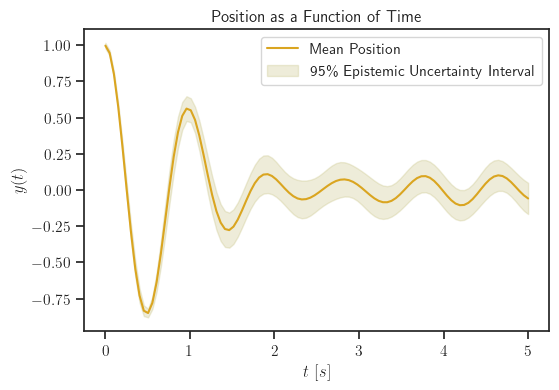

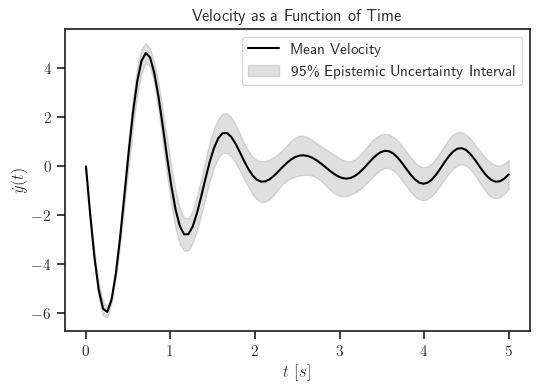

In [9]:
# define number of samples to use and take them using function defined above
N = 100
samples = take_samples_from_solver(N)
# Sampled positions are: samples[:, :, 0]
# Sampled velocities are: samples[:, :, 1]
# Sampled position at the 10th timestep is: samples[:, 9, 0]
# etc.

# extracting data from array
samplePositions = samples[:, :, 0] # an N x nt = 100 x 100 array
sampleVelocities = samples[:, :, 1] # an N x nt = 100 x 100 array

# calculate average position and velocity from the data
avgPos = np.mean(samplePositions, axis=0)
avgVel = np.mean(sampleVelocities, axis=0)

# calculate variance, and standard deviation of the sample positions and velocities, respectively
varPos = np.var(samplePositions, axis=0)
varVel = np.var(sampleVelocities, axis=0)
stddevPos = np.sqrt(varPos)
stddevVel = np.sqrt(varVel)

# calculate upper and lower profiles for 95% epistemic uncertainty interval for both position and velocity
upperProfilePos = avgPos + (2/np.sqrt(N))*stddevPos
lowerProfilePos = avgPos - (2/np.sqrt(N))*stddevPos
upperProfileVel = avgVel + (2/np.sqrt(N))*stddevVel
lowerProfileVel = avgVel - (2/np.sqrt(N))*stddevVel

# plotting results:
# first for position
fig, ax = plt.subplots()
ax.plot(solver.t, avgPos, color='goldenrod', label="Mean Position")
ax.fill_between(solver.t, lowerProfilePos, upperProfilePos,
                label="95\% Epistemic Uncertainty Interval", color='darkkhaki', alpha=0.25)
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$y(t)$")
ax.set_title("Position as a Function of Time")
plt.legend(loc="best")

# second for velocity
fig, ax = plt.subplots()
ax.plot(solver.t, avgVel, color='black', label="Mean Velocity")
ax.fill_between(solver.t, lowerProfileVel, upperProfileVel,
                label="95\% Epistemic Uncertainty Interval", color='gray', alpha=0.25)
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$\dot{y}(t)$")
ax.set_title("Velocity as a Function of Time")
plt.legend(loc="best")

### Part B

Plot the epistemic uncertainty about the mean position at $t=5$s as a function of the number of samples. 

**Solution**:

Note: The epistemic uncertainty about the mean velocity at $t=5$s as a function of the number of samples was also plotted for exercise and completeness purposes.

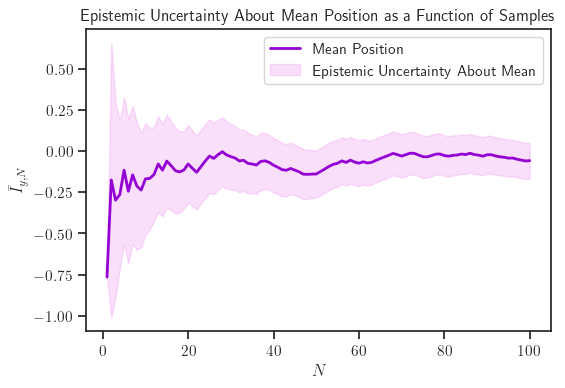

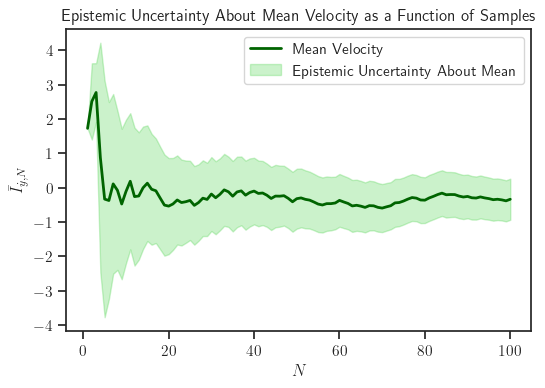

In [10]:
# extracting necessary data (at time t = 5s)
samplePositions5s = samples[:, -1, 0] # an N x 1 = 100 x 1 array
sampleVelocities5s = samples[:, -1, 1] # an N x 1 = 100 x 1 array
# variable to re-use for x-axis values (number of samples) to plot against
nVals = np.arange(1, N+1)

# ***** Position *****
# calculate the sample average for the position
yavg_running = np.cumsum(samplePositions5s) / nVals
# calculate the sample average for the squared of the position
gy2_running = np.cumsum(samplePositions5s**2) / nVals
# calculate the running average of the variance of the position
sigmay2_running = gy2_running - yavg_running**2
# Using CLT, calculating the upper and lower ranges for the 95% epistemic uncertainty interval
y_lower_running = yavg_running - 2.0*np.sqrt(sigmay2_running / nVals)
y_upper_running = yavg_running + 2.0*np.sqrt(sigmay2_running / nVals)

# ***** Velocity *****
# calculate the sample average for the velocity
ydotavg_running = np.cumsum(sampleVelocities5s) / nVals
# calculate the sample average for the squared of the velocity
gydot2_running = np.cumsum(sampleVelocities5s**2) / nVals
# calculate the running average of the variance of the velocity
sigmaydot2_running = gydot2_running - ydotavg_running**2
# Using CLT, calculating the upper and lower ranges for the 95% epistemic uncertainty interval
ydot_lower_running = ydotavg_running - 2.0*np.sqrt(sigmaydot2_running / nVals)
ydot_upper_running = ydotavg_running + 2.0*np.sqrt(sigmaydot2_running / nVals)

# ***** Plotting Results *****
fig, ax = plt.subplots()
ax.plot(nVals, yavg_running, label="Mean Position", color='darkviolet', lw=2)
ax.fill_between(nVals, y_lower_running, y_upper_running,
                label="Epistemic Uncertainty About Mean", color='violet', alpha=0.25)
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\bar{I}_{y,N}$');
ax.set_title("Epistemic Uncertainty About Mean Position as a Function of Samples")
plt.legend(loc="best")

fig, ax = plt.subplots()
ax.plot(nVals, ydotavg_running, label="Mean Velocity", color='darkgreen', lw=2)
ax.fill_between(nVals, ydot_lower_running, ydot_upper_running,
                label="Epistemic Uncertainty About Mean", color='limegreen', alpha=0.25)
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\bar{I}_{\dot{y},N}$');
ax.set_title("Epistemic Uncertainty About Mean Velocity as a Function of Samples")
plt.legend(loc="best")

### Part C
Repeat part A and B for the squared response.
That is, do exactly the same thing as above, but consider $y^2(t)$ and $\dot{y}^2(t)$ instead of $y(t)$ and $\dot{y}(t)$.
How many samples do you need to estimate the mean squared response at $t=5$s with negligible epistemic uncertainty?

**Solution**:

The setup for this problem is very similar to that in Part A, except now the normal distributions of interest are:

$$
I_{y^{2}} \sim N\left(\bar{I}_{y^{2},N}, \frac{\bar{\sigma}_{y^{2},N}^{2}}{N}\right)
$$

$$
I_{\dot{y}^{2}} \sim N\left(\bar{I}_{\dot{y}^{2},N}, \frac{\bar{\sigma}_{\dot{y}^{2},N}^{2}}{N}\right)
$$

where we want to find:

$$
I_{y^{2}} \approx \bar{I}_{y^{2},N} \pm \frac{2}{\sqrt{N}}\bar{\sigma}_{y^{2},N},
$$

$$
I_{\dot{y^{2}}} \approx \bar{I}_{\dot{y^{2}},N} \pm \frac{2}{\sqrt{N}}\bar{\sigma}_{\dot{y^{2}},N},
$$

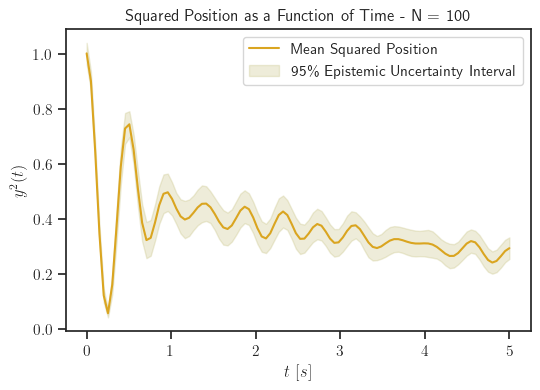

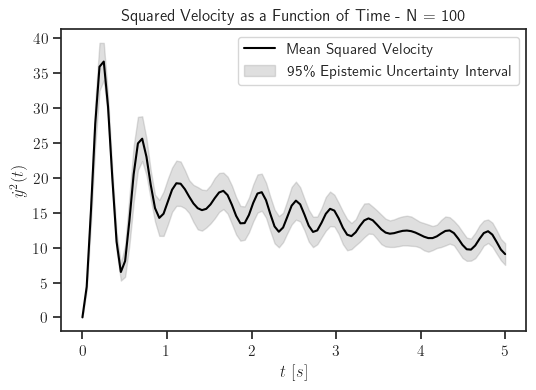

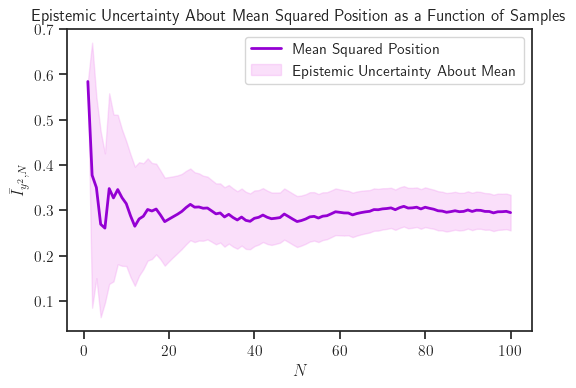

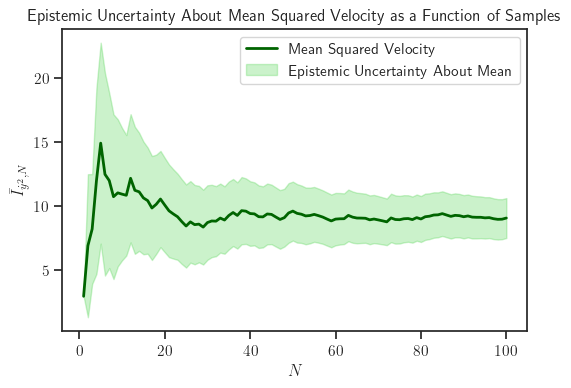

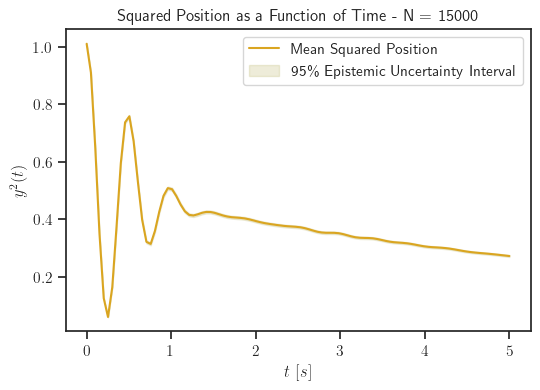

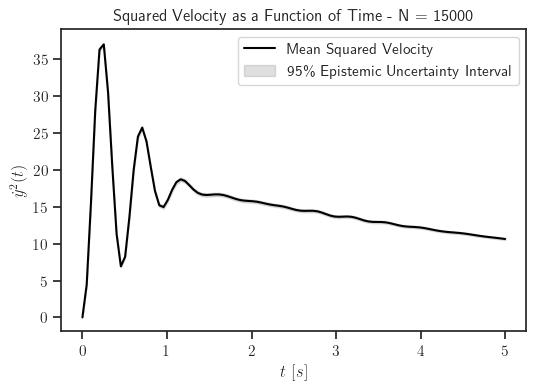

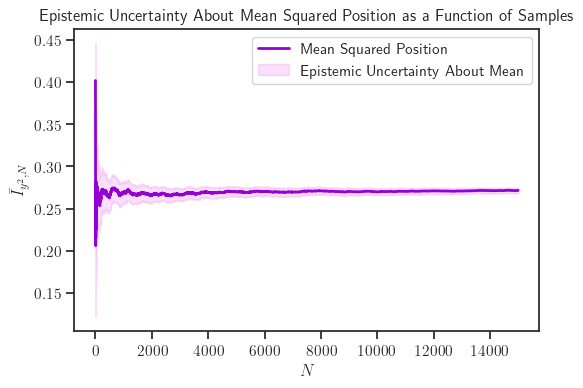

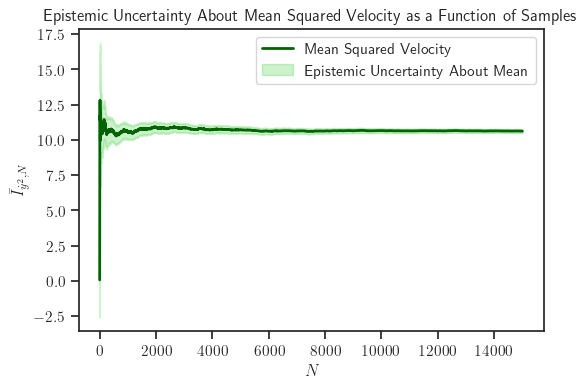

In [11]:
# &&&&&&&&&& Repeating Part A for Squared Response &&&&&&&&&&
# square positions and velocities
samplePositions2 = samplePositions**2
sampleVelocities2 = sampleVelocities**2

# calculate average position and velocity from the data
avgPos2 = np.mean(samplePositions2, axis=0)
avgVel2 = np.mean(sampleVelocities2, axis=0)

# calculate variance, and standard deviation of the sample positions and velocities, respectively
varPos2 = np.var(samplePositions2, axis=0)
varVel2 = np.var(sampleVelocities2, axis=0)
stddevPos2 = np.sqrt(varPos2)
stddevVel2 = np.sqrt(varVel2)

# calculate upper and lower profiles for 95% epistemic uncertainty interval for both position and velocity
upperProfilePos2 = avgPos2 + (2/np.sqrt(N))*stddevPos2
lowerProfilePos2 = avgPos2 - (2/np.sqrt(N))*stddevPos2
upperProfileVel2 = avgVel2 + (2/np.sqrt(N))*stddevVel2
lowerProfileVel2 = avgVel2 - (2/np.sqrt(N))*stddevVel2

# plotting results:
# first for position
fig, ax = plt.subplots()
ax.plot(solver.t, avgPos2, color='goldenrod', label="Mean Squared Position")
ax.fill_between(solver.t, lowerProfilePos2, upperProfilePos2,
                label="95\% Epistemic Uncertainty Interval", color='darkkhaki', alpha=0.25)
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$y^{2}(t)$")
ax.set_title("Squared Position as a Function of Time - N = 100")
plt.legend(loc="best")
# second for velocity
fig, ax = plt.subplots()
ax.plot(solver.t, avgVel2, color='black', label="Mean Squared Velocity")
ax.fill_between(solver.t, lowerProfileVel2, upperProfileVel2,
                label="95\% Epistemic Uncertainty Interval", color='gray', alpha=0.25)
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$\dot{y}^{2}(t)$")
ax.set_title("Squared Velocity as a Function of Time - N = 100")
plt.legend(loc="best")

# &&&&&&&&&& Repeating Part B for Squared Response &&&&&&&&&&
# square positions and velocities at t = 5s
samplePositions5s2 = samplePositions5s**2
sampleVelocities5s2 = sampleVelocities5s**2

# ***** Position ******
# calculate the sample average for the position squared
yavg_running2 = np.cumsum(samplePositions5s2) / nVals
# calculate the sample average for the squared of the position squared
gy2_running2 = np.cumsum(samplePositions5s2**2) / nVals
# calculate the running average of the variance of the position squared
sigmay2_running2 = gy2_running2 - yavg_running2**2
# Using CLT, calculating the upper and lower ranges for the 95% epistemic uncertainty interval
y_lower_running2 = yavg_running2 - 2.0*np.sqrt(sigmay2_running2 / nVals)
y_upper_running2 = yavg_running2 + 2.0*np.sqrt(sigmay2_running2 / nVals)

# ***** Velocity *****
# calculate the sample average for the velocity squared
ydotavg_running2 = np.cumsum(sampleVelocities5s2) / nVals
# calculate the sample average for the squared of the velocity squared
gydot2_running2 = np.cumsum(sampleVelocities5s2**2) / nVals
# calculate the running average of the variance of the velocity squared
sigmaydot2_running2 = gydot2_running2 - ydotavg_running2**2
# Using CLT, calculating the upper and lower ranges for the 95% epistemic uncertainty interval
ydot_lower_running2 = ydotavg_running2 - 2.0*np.sqrt(sigmaydot2_running2 / nVals)
ydot_upper_running2 = ydotavg_running2 + 2.0*np.sqrt(sigmaydot2_running2 / nVals)

# ***** Plotting Results *****
fig, ax = plt.subplots()
ax.plot(nVals, yavg_running2, label="Mean Squared Position", color='darkviolet', lw=2)
ax.fill_between(nVals, y_lower_running2, y_upper_running2,
                label="Epistemic Uncertainty About Mean", color='violet', alpha=0.25)
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\bar{I}_{y^{2},N}$');
ax.set_title("Epistemic Uncertainty About Mean Squared Position as a Function of Samples")
plt.legend(loc="best")

fig, ax = plt.subplots()
ax.plot(nVals, ydotavg_running2, label="Mean Squared Velocity", color='darkgreen', lw=2)
ax.fill_between(nVals, ydot_lower_running2, ydot_upper_running2,
                label="Epistemic Uncertainty About Mean", color='limegreen', alpha=0.25)
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\bar{I}_{\dot{y}^{2},N}$');
ax.set_title("Epistemic Uncertainty About Mean Squared Velocity as a Function of Samples")
plt.legend(loc="best")

# &&&&& Using more samples to plot squared response &&&&&
newN = 15000
newSamples = take_samples_from_solver(newN)

newsamplePositions = newSamples[:, :, 0] # an N x nt array
newsampleVelocities = newSamples[:, :, 1] # an N x nt array

# square positions and velocities
newsamplePositions2 = newsamplePositions**2
newsampleVelocities2 = newsampleVelocities**2

# calculate average position and velocity from the data
newavgPos2 = np.mean(newsamplePositions2, axis=0)
newavgVel2 = np.mean(newsampleVelocities2, axis=0)

# calculate variance, and standard deviation of the sample positions and velocities, respectively
newvarPos2 = np.var(newsamplePositions2, axis=0)
newvarVel2 = np.var(newsampleVelocities2, axis=0)
newstddevPos2 = np.sqrt(newvarPos2)
newstddevVel2 = np.sqrt(newvarVel2)

# calculate upper and lower profiles for 95% epistemic uncertainty interval for both position and velocity
newupperProfilePos2 = newavgPos2 + (2/np.sqrt(newN))*newstddevPos2
newlowerProfilePos2 = newavgPos2 - (2/np.sqrt(newN))*newstddevPos2
newupperProfileVel2 = newavgVel2 + (2/np.sqrt(newN))*newstddevVel2
newlowerProfileVel2 = newavgVel2 - (2/np.sqrt(newN))*newstddevVel2

# plotting results:
# first for position
fig, ax = plt.subplots()
ax.plot(solver.t, newavgPos2, color='goldenrod', label="Mean Squared Position")
ax.fill_between(solver.t, newlowerProfilePos2, newupperProfilePos2,
                label="95\% Epistemic Uncertainty Interval", color='darkkhaki', alpha=0.25)
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$y^{2}(t)$")
ax.set_title("Squared Position as a Function of Time - N = 15000")
plt.legend(loc="best")
# second for velocity
fig, ax = plt.subplots()
ax.plot(solver.t, newavgVel2, color='black', label="Mean Squared Velocity")
ax.fill_between(solver.t, newlowerProfileVel2, newupperProfileVel2,
                label="95\% Epistemic Uncertainty Interval", color='gray', alpha=0.25)
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$\dot{y}^{2}(t)$")
ax.set_title("Squared Velocity as a Function of Time - N = 15000")
plt.legend(loc="best")

# &&&&& Repeating Part B once more, with more samples now &&&&&
# extracting data from array
newSamplePositions5s = newSamples[:, -1, 0] # an newN x 1 array
newSampleVelocities5s = newSamples[:, -1, 1] # an newN x 1 array
# variable to re-use for x-axis values (number of samples) to plot against
newnVals = np.arange(1, newN+1)
# define new set of squared positions and velocities at t = 5s
newSamplePositions5s2 = newSamplePositions5s**2
newSampleVelocities5s2 = newSampleVelocities5s**2

# ***** Position ******
# calculate the sample average for the position squared
newyavg_running2 = np.cumsum(newSamplePositions5s2) / newnVals
# calculate the sample average for the squared of the position squared
newgy2_running2 = np.cumsum(newSamplePositions5s2**2) / newnVals
# calculate the running average of the variance of the position squared
newsigmay2_running2 = newgy2_running2 - newyavg_running2**2
# Using CLT, calculating the upper and lower ranges for the 95% epistemic uncertainty interval
newy_lower_running2 = newyavg_running2 - 2.0*np.sqrt(newsigmay2_running2 / newnVals)
newy_upper_running2 = newyavg_running2 + 2.0*np.sqrt(newsigmay2_running2 / newnVals)

# ***** Velocity *****
# calculate the sample average for the velocity squared
newydotavg_running2 = np.cumsum(newSampleVelocities5s2) / newnVals
# calculate the sample average for the squared of the velocity squared
newgydot2_running2 = np.cumsum(newSampleVelocities5s2**2) / newnVals
# calculate the running average of the variance of the velocity squared
newsigmaydot2_running2 = newgydot2_running2 - newydotavg_running2**2
# Using CLT, calculating the upper and lower ranges for the 95% epistemic uncertainty interval
newydot_lower_running2 = newydotavg_running2 - 2.0*np.sqrt(newsigmaydot2_running2 / newnVals)
newydot_upper_running2 = newydotavg_running2 + 2.0*np.sqrt(newsigmaydot2_running2 / newnVals)

# ***** Plotting Results *****
fig, ax = plt.subplots()
ax.plot(newnVals, newyavg_running2, label="Mean Squared Position", color='darkviolet', lw=2)
ax.fill_between(newnVals, newy_lower_running2, newy_upper_running2,
                label="Epistemic Uncertainty About Mean", color='violet', alpha=0.25)
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\bar{I}_{y^{2},N}$');
ax.set_title("Epistemic Uncertainty About Mean Squared Position as a Function of Samples")
plt.legend(loc="best")

fig, ax = plt.subplots()
ax.plot(newnVals, newydotavg_running2, label="Mean Squared Velocity", color='darkgreen', lw=2)
ax.fill_between(newnVals, newydot_lower_running2, newydot_upper_running2,
                label="Epistemic Uncertainty About Mean", color='limegreen', alpha=0.25)
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\bar{I}_{\dot{y}^{2},N}$');
ax.set_title("Epistemic Uncertainty About Mean Squared Velocity as a Function of Samples")
plt.legend(loc="best")

**Part C Discussion:**

The number of samples required to estimate the mean squared response at $t=5$s with negligible epistemic uncertainty is subjective. This is because 'negligible epistemic uncertainty' may be interpreted differently depending on what degree of uncertainty is acceptable. A few alternative methods exist for determining when epistemic uncertainty is negligible, using the running average with 95% epistemic uncertainty interval (purple and green above) plots:

1) **Look for a certain 95\% epistemic uncertainty interval size:** Increment N and continue to compute the running sample average. For each N, calculate the difference between the upper and lower 95\% epistemic uncertainty interval curves. Once this difference reaches or falls below some set threshold value, convergence is complete.

2) **Look for a certain rate-of-change in the curve:** Increment N and continue to compute the running sample average. Once N reaches 2 or more, use a numerical differentiation method to approximate the current derivative for the running average vs N curve. Once this derivative reaches or falls below some set threshold value, convergence is complete.

Of course, the selected threshold values in either situation will depend on system requirements based on the particular situation. In addition, the additional computational costs for further sampling must always be considered. 

Given the open-endedness of what level of epistemic uncertainty may be 'acceptable' in this problem, the number of required samples to estimate the mean squared response at $t=5$s with negligible epistemic uncertainty was selected to be $N = 15000$. This number was selected on a purely qualitative basis, as the running average plots above appear to have zero slope and negligible epistemic uncertainty intervals at $N \approx 15000$.

### Part D

Now that you know how many samples you need to estimate the mean of the response and the square response, use the formula:

$$
\mathbb{V}[y(t)] = \mathbb{E}[y^2(t)] - \left(\mathbb{E}[y(t)]\right)^2,
$$

and similarly for $\dot{y}(t)$, to estimate the variance of the position and the velocity with negligible epistemic uncertainty.
Plot both quantities as a function of time.

**Solution**:

Text(0.5, 1.0, 'Variance of $\\dot{y}(t)$ Using Data Directly')

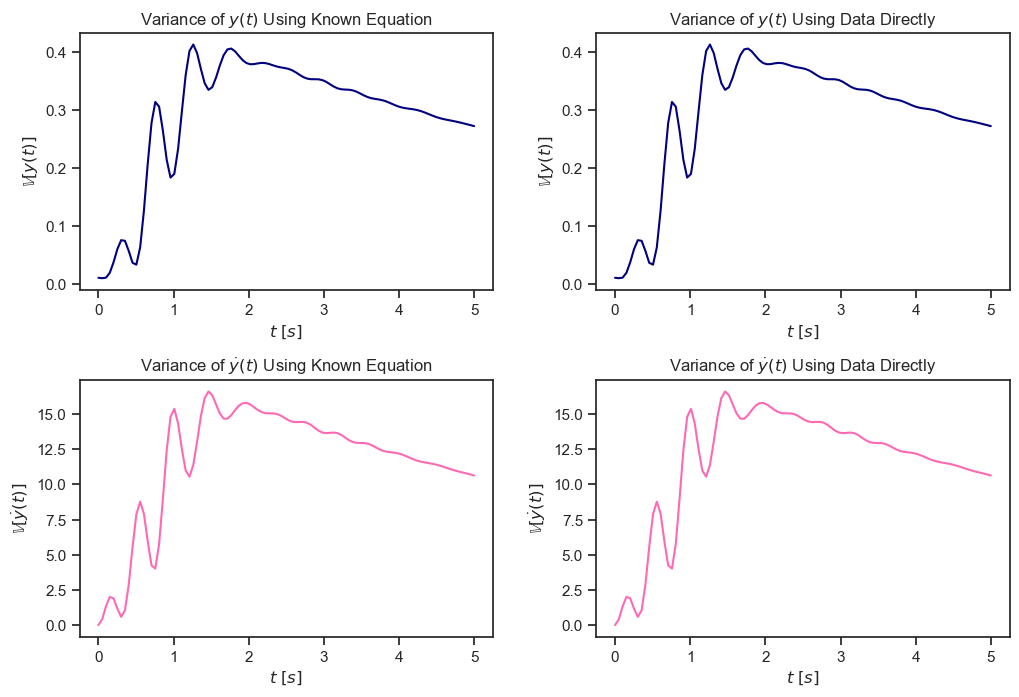

In [12]:
rc('text', usetex=False)
# keeping same variable names, repeating prior process (from part A) with the set of more samples
samples = newSamples
# extracting data from array
samplePositions = samples[:, :, 0] # an N x nt array
sampleVelocities = samples[:, :, 1] # an N x nt array
# calculate average position and velocity from the data
avgPos = np.mean(samplePositions, axis=0)
avgVel = np.mean(sampleVelocities, axis=0)
# square positions and velocities
samplePositions2 = samplePositions**2
sampleVelocities2 = sampleVelocities**2
# calculate average position and velocity from the data
avgPos2 = np.mean(samplePositions2, axis=0)
avgVel2 = np.mean(sampleVelocities2, axis=0)
# **********************************************************************

# using the formula provided above and solutions from the previous sections:
varPosEq = avgPos2 - avgPos**2
varVelEq = avgVel2 - avgVel**2

# alternative - use the built-in function to calculate variance by using all of the data directly
varPosData = np.var(samplePositions, axis=0)
varVelData = np.var(sampleVelocities, axis=0)

# plotting results
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
fig.subplots_adjust(wspace=0.25, hspace=0.35)
# ... using the equation (which is what the assignment asks for)
axs[0, 0].plot(solver.t, varPosEq, color='navy', label="Var Pos")
axs[0, 0].set_xlabel(r"$t$" + " " + r"$ [s]$")
axs[0, 0].set_ylabel(r"$\mathbb{V}[y(t)]$")
axs[0, 0].set_title("Variance of $y(t)$ Using Known Equation")
axs[1, 0].plot(solver.t, varVelEq, color='hotpink', label="Var Vel")
axs[1, 0].set_xlabel(r"$t$" + " " + r"$ [s]$")
axs[1, 0].set_ylabel(r"$\mathbb{V}[\dot{y}(t)]$")
axs[1, 0].set_title("Variance of $\dot{y}(t)$ Using Known Equation")
# ... using the built-in and using all of the data directly (for exercise purposes)
axs[0, 1].plot(solver.t, varPosData, color='navy', label="Var Pos")
axs[0, 1].set_xlabel(r"$t$" + " " + r"$ [s]$")
axs[0, 1].set_ylabel(r"$\mathbb{V}[y(t)]$")
axs[0, 1].set_title("Variance of $y(t)$ Using Data Directly")
axs[1, 1].plot(solver.t, varVelData, color='hotpink', label="Var Vel")
axs[1, 1].set_xlabel(r"$t$" + " " + r"$ [s]$")
axs[1, 1].set_ylabel(r"$\mathbb{V}[\dot{y}(t)]$")
axs[1, 1].set_title("Variance of $\dot{y}(t)$ Using Data Directly")

**Part D Discussion:**

The results on the left hand side are the ones that adhere to the original problem statement of the question. The results on the right hand side are the ones that correspond to an extra exercise. The exercise was to explore how variance can be calculated in multiple ways in Python. Ultimately, the results for the variance for the position and velocity are the same and this concludes that either method (using the variance equation or np.var()) yields the same results.

### Part E

Put together the estimated mean and variance to plot a 95% predictive interval for the position and the velocity as functions of time.

Hint: You need to use the Central Limit Theorem. Check out the corresponding textbook example.

**Solution**:

In order to account for both epistemic and aleatory uncertainty, the equations of interest for the average position and velocity become:

$$
I_{y} \approx \bar{I}_{y,N} \pm 2\bar{\sigma}_{y,N},
$$

$$
I_{\dot{y}} \approx \bar{I}_{\dot{y},N} \pm 2\bar{\sigma}_{\dot{y},N},
$$

where $\frac{1}{\sqrt{N}}$ is no longer contributing to the upper and lower profiles for the uncertainty interval. The class Piazza page was referenced to help gain a better understanding.

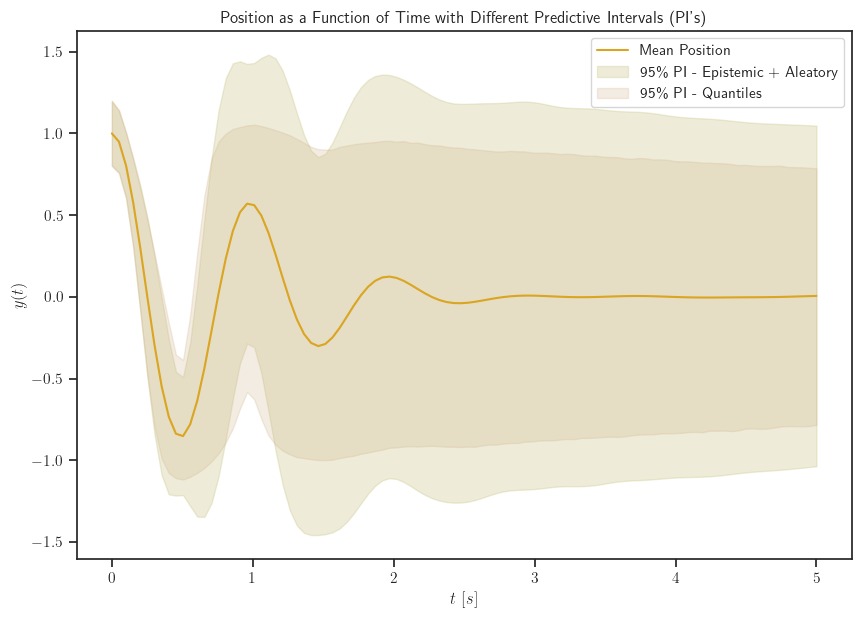

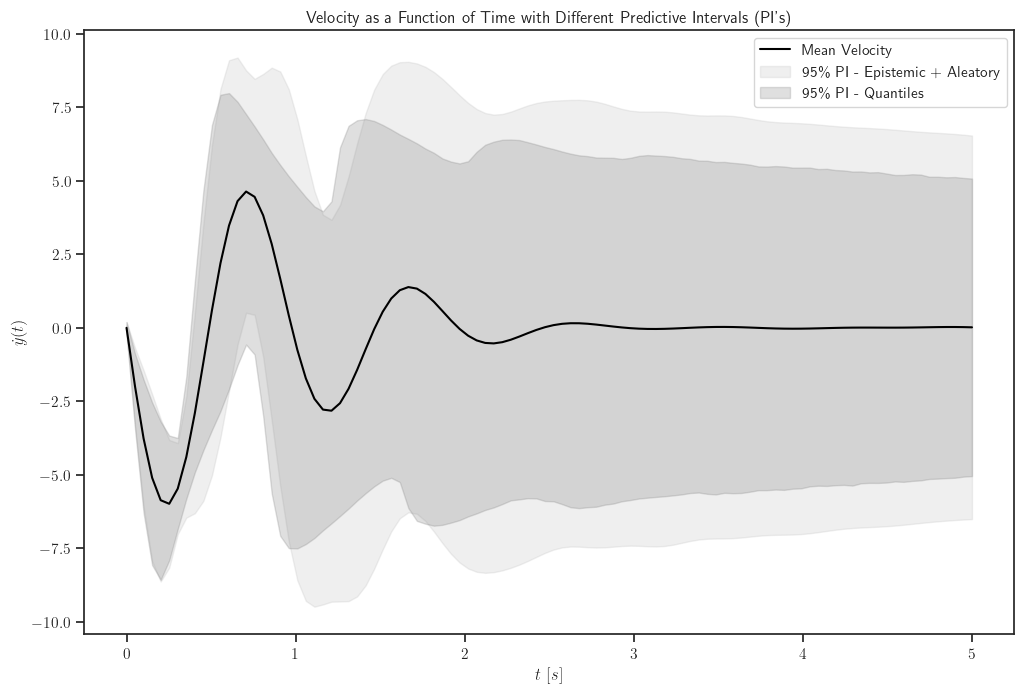

In [13]:
rc('text', usetex=True)
# calculating standard deviation of position and velocity using variance derived by the known equation
stddevPosEq = np.sqrt(varPosEq)
stddevVelEq = np.sqrt(varVelEq)

# calculate upper and lower profiles for 95% predictive interval (PI) for both position and velocity
# this interval accounts for both epistemic and aleatory uncertainty
upperProfilePosEq = avgPos + (2*stddevPosEq)
lowerProfilePosEq = avgPos - (2*stddevPosEq)
upperProfileVelEq = avgVel + (2*stddevVelEq)
lowerProfileVelEq = avgVel - (2*stddevVelEq)
# --> also calculate quantiles for comparison
mu_025Pos, mu_975Pos = np.quantile(samplePositions, [0.025, 0.975], axis=0)
mu_025Vel, mu_975Vel = np.quantile(sampleVelocities, [0.025, 0.975], axis=0)

# plotting results:
# first for position
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(solver.t, avgPos, color='goldenrod', label="Mean Position")
ax.fill_between(solver.t, lowerProfilePosEq, upperProfilePosEq,
                label="95\% PI - Epistemic + Aleatory", color='darkkhaki', alpha=0.25)
# quantiles to compare
ax.fill_between(solver.t, mu_025Pos, mu_975Pos,
                alpha=0.25, label="95\% PI - Quantiles", color='tan')
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$y(t)$")
ax.set_title("Position as a Function of Time with Different Predictive Intervals (PI's)")
plt.legend(loc="best")

# second for velocity
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(solver.t, avgVel, color='black', label="Mean Velocity")
ax.fill_between(solver.t, lowerProfileVelEq, upperProfileVelEq,
                label="95\% PI - Epistemic + Aleatory", color='silver', alpha=0.25)
# quantiles to compare
ax.fill_between(solver.t, mu_025Vel, mu_975Vel,
                alpha=0.25, label="95\% PI - Quantiles", color='gray')
ax.set_xlabel(r"$t$" + " " + r"$ [s]$")
ax.set_ylabel(r"$\dot{y}(t)$")
ax.set_title("Velocity as a Function of Time with Different Predictive Intervals (PI's)")
plt.legend(loc="best")

**Part E Discussion:**

The above plot includes two different predictive intervals: one that uses an epistemic & aleatory uncertainty approach and another that uses an extreme quantile approach. The uncertainty intervals are similar when $t \approx 0$s, and become more distinct from one another when $t \approx 1$s. Plotting both predictive intervals was an optional exercise to observe and discuss the differences between the two.

The extreme quantile approach results in an interval that includes exactly 95% of the available probability, since $z_{2.5}$ and $z_{97.5}$ are used. The epistemic & aleatory uncertainty approach results in slightly more than 95% of the available probability due to the 68-95-99.7 rule [1]. Part of the rule states that $\approx 95.45\%$ of observations from a normal distribution lie within a $\pm 2\sigma$ interval about the mean, $\mu$. As a result, this approach results in an interval that is slightly wider than the previous.

**Sources:**

[1] https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

## Problem 2 - Earthquakes again

The [San Andreas fault](https://en.wikipedia.org/wiki/San_Andreas_Fault) extends through California forming the boundary between the Pacific and the North American tectonic plates.
It has caused some of the major earthquakes on Earth.
We are going to focus on Southern California and we would like to assess the probability of a major earthquake, defined as an earthquake of magnitude 6.5 or greater, during the next ten years.

A. The first thing we are going to do is go over a [database of past earthquakes](https://scedc.caltech.edu/significant/chron-index.html) that have occured in Southern California and collect the relevant data. We are going to start at 1900 because data before that time may are unreliable.
Go over each decade and count the occurence of a major earthquake (i.e., count the number of organge and red colors in each decade). We have done this for you.

In [14]:
eq_data = np.array([
    0, # 1900-1909
    1, # 1910-1919
    2, # 1920-1929
    0, # 1930-1939
    3, # 1940-1949
    2, # 1950-1959
    1, # 1960-1969
    2, # 1970-1979
    1, # 1980-1989
    4, # 1990-1999
    0, # 2000-2009
    2 # 2010-2019 
])

Let's visualize them:

Text(0.5, 1.0, 'Bar Chart of Earthquake Data')

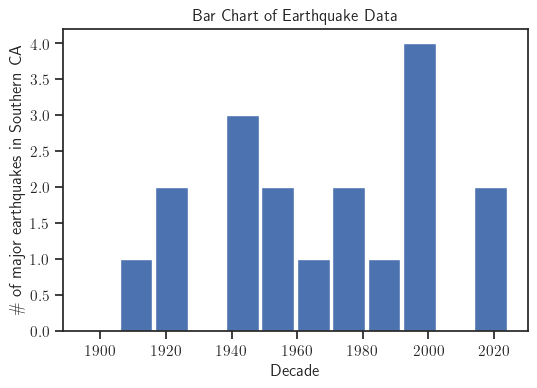

In [15]:
fig, ax = plt.subplots()
ax.bar(
    np.linspace(1900, 2019, eq_data.shape[0]),
    eq_data,
    width=10
)
ax.set_xlabel('Decade')
ax.set_ylabel('\# of major earthquakes in Southern CA')
ax.set_title('Bar Chart of Earthquake Data')

A. The right way to model the number of earthquakes $X_n$ in a decade $n$ is using a Poisson distribution with unknown rate parameter $\lambda$, i.e.,

$$
X_n | \lambda \sim \operatorname{Poisson}(\lambda).
$$

The probability mass function is:

$$
p(x_n|\lambda) \equiv p(X_n=x_n|\lambda) = \frac{\lambda^{x_n}}{x_n!}e^{-\lambda}.
$$

Here we have $N = 12$ observations, say $x_{1:N} = (x_1,\dots,x_N)$ (stored in ``eq_data`` above).
Find the *joint probability mass function* (otherwise known as the likelihood) $p(x_{1:N}|\lambda)$ of these random variables.<br>
*Hint: Assume that all measurements are independent. Then their joint pmf is the product of the individual pmfs.
You should be able to simplify the expression considerably.*
<br>
**Answer:**

General solution for arbitrary $N$:

$$
\begin{split}
p(x_{1:N}|\lambda) &= \prod_{n=1}^Np(x_n|\lambda)\\
&= \prod_{n=1}^N\frac{\lambda^{x_n}}{x_n!}e^{-\lambda}\\
&= \frac{\lambda^{\sum_{n=1}^Nx_n}}{\prod_{n=1}^Nx_n!}e^{-N\lambda}
\end{split}
$$

In this particular case, since we have $N = 12$ observations from the earthquake data, we can reduce the expression to:

$$
\begin{split}
p(x_{1:12}|\lambda) &= \frac{\lambda^{\sum_{n=1}^{12}x_n}}{\prod_{n=1}^{12}x_n!}e^{-12\lambda}\\
&= \frac{1}{2304}\lambda^{18}e^{-12\lambda}
\end{split}
$$

B. The rate parameter $\lambda$ (number of major earthquakes per ten years) is positive. What prior distribution should we assign to it if we expect it to be around 2?
A convenient choice here is to pick a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution), see also [the scipy.stats page for the Gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) because it results in an analytical posterior.
We write:

$$
\lambda \sim \operatorname{Gamma}(\alpha, \beta),
$$

where $\alpha$ and $\beta$ are positive *hyper-parameters* that we have to set to represent our prior state of knowledge.
The PDF is:

$$
p(\lambda) = \frac{\beta^\alpha \lambda^{\alpha-1}e^{-\beta \lambda}}{\Gamma(\alpha)},
$$

where we are not conditioning on $\alpha$ and $\beta$ because they should be fixed numbers.
Use the code below to pick some some reasonable values for $\alpha$ and $\beta$.
<br>
**Just enter your choice of $\alpha$ and $\beta$ in the code block below.**
<br>
Hint: Notice that the maximum entropy distribution for a positive parameter with known expectation is the [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution), e.g., see the Table in [this wiki page](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution). Then notice that the Exponential is a special case of the Gamma (set $\alpha=1$).

Text(0.5, 1.0, 'Prior PDF of $\\lambda$')

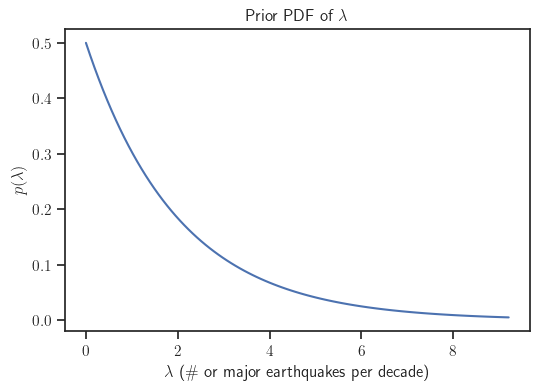

In [16]:
import scipy.stats as st

# For maximum entropy, pick alpha to be 1
alpha = 1.0
# According to documentation at https://en.wikipedia.org/wiki/Gamma_distribution,
# the mean of an rv that follows a gamma is: alpha/beta = 2 (in this case)
expectation = 2
# Therefore, solving for beta:
beta = alpha/expectation

# This is the prior on lambda:
lambda_prior = st.gamma(alpha, scale=1.0 / beta) 

# Let's plot it:
lambdas_prior = np.linspace(0, lambda_prior.ppf(0.99), 100)
fig, ax = plt.subplots()
ax.plot(lambdas_prior, lambda_prior.pdf(lambdas_prior))
ax.set_xlabel('$\lambda$ (\# or major earthquakes per decade)')
ax.set_ylabel('$p(\lambda)$')
ax.set_title('Prior PDF of $\lambda$')

C. Show that the posterior of $\lambda$ conditioned on $x_{1:N}$ is also a Gamma, but with updated hyperparameters.
<br>
Hint: When you write down the posterior of $\lambda$ you can drop any multiplicative term that does not depend on it as it will be absorbed in the normalization constnat. This will simplify the notation a little bit.
<br>
**Answer:**

$$
\text{posterior} \propto \text{likelihood}\times\text{prior}.
$$

$$
\begin{split}
p(\lambda|x_{1:N}) &\propto p(x_{1:N}|\lambda)p(\lambda)\\
&= \left(\frac{\lambda^{\sum_{n=1}^Nx_n}}{\prod_{n=1}^Nx_n!}e^{-N\lambda}\right)\left(\frac{\beta^\alpha \lambda^{\alpha-1}e^{-\beta \lambda}}{\Gamma(\alpha)}\right)\\
&= C\left(\frac{\beta^\alpha}{\Gamma(\alpha)}\lambda^{\sum_{n=1}^Nx_n + \alpha-1}e^{-(N+\beta)\lambda}\right); C=\frac{1}{\prod_{n=1}^Nx_n!}\\
&\propto \left(\frac{\beta^\alpha}{\Gamma(\alpha)}\lambda^{\sum_{n=1}^Nx_n + \alpha-1}e^{-(N+\beta)\lambda}\right)
\end{split}
$$

The updated hyperparameters are:

$$
\alpha_{post} \gets \sum_{n=1}^Nx_n + \alpha
$$

$$
\beta_{post} \gets N + \beta
$$

The posterior then follows the below Gamma distribution. The general solution for arbitrary $N$ is:

$$
\lambda|x_{1:N} \sim \operatorname{Gamma}\left(\sum_{n=1}^Nx_n + \alpha, N + \beta\right) ; \alpha = 1, \beta = 0.5
$$

In this particular case, since we have $N = 12$ observations from the earthquake data, we can reduce the expression to:

$$
\begin{split}
\lambda|x_{1:N} &\sim \operatorname{Gamma}\left(18 + \alpha, 12 + \beta\right)\\
&\sim \operatorname{Gamma}\left(19, 12.5\right)
\end{split}
$$

D. Prior-likelihood pairs that result in a posterior with the same form as the prior as known as conjugate distributions. Conjugate distributions are your only hope for analytical Bayesian inference.
As a sanity check, look at the wikipedia page for [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior), locate the Poisson-Gamma pair and verify your answer above.
<br>
*Nothing to report here. Just do it as a sanity check.*
<br>
**Answer:**

Yes, the answer above follows the known Poisson-Gamma conjugate distribution.

E. Plot the prior and the posterior of $\lambda$ on the same plot.

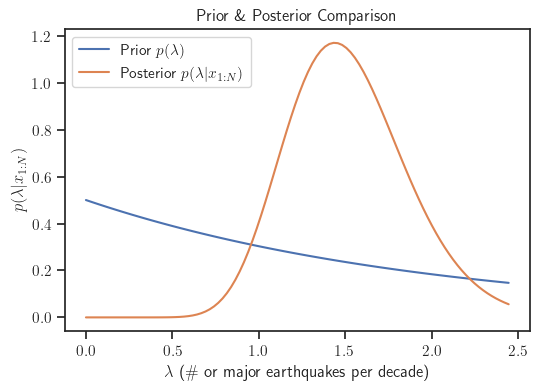

In [17]:
# Your expression for alpha posterior here:
alpha_post = alpha + np.sum(eq_data)
# Your expression for beta posterior here:
beta_post = beta + len(eq_data)
# The posterior
lambda_post = st.gamma(alpha_post, scale=1.0 / beta_post)

# Plot it
lambdas_post = np.linspace(0, lambda_post.ppf(0.99), 100)
fig, ax = plt.subplots()
ax.plot(lambdas_post, lambda_prior.pdf(lambdas_post),
        label='Prior $p(\lambda)$')
ax.plot(lambdas_post, lambda_post.pdf(lambdas_post),
        label='Posterior $p(\lambda|x_{1:N})$')
ax.set_xlabel('$\lambda$ (\# or major earthquakes per decade)')
ax.set_ylabel('$p(\lambda|x_{1:N})$')
ax.set_title('Prior \& Posterior Comparison')
plt.legend(loc="best")

F. Let's work out the predictive distribution for the number of major earthquakes during the next decade.
This is something that we did not do in class, but it will appear again and again in future lectures.
Let $X$ be the random variable corresponding to the number of major eathquakes during the next decade.
We need to calculate:

$$
p(x|x_{1:N}) = \text{our state of knowledge about $X$ after seeing the data}.
$$

How do we do this?
We just use the sum rule:

$$
p(x|x_{1:N}) = \int_{0}^\infty p(x|\lambda, x_{1:N}) p(\lambda|x_{1:N})d\lambda = \int_{0}^\infty p(x|\lambda) p(\lambda|x_{1:N})d\lambda,
$$

where going from the middle step to the rightmost one we used the assumption that the number of earthquakes occuring in each decade is independent.
You can carray out this integration analytically (it gives a [negative Binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) distribution) but we are not going to bother with it.

Below you are going to write code to characterize it using Monte Carlo sampling.
Basically, you can take a sample from the posterior predictive by:

+ sampling a $\lambda$ from its posterior $p(\lambda|x_{1:N})$.
+ sampling an $x$ from the likelihood $p(x|\lambda)$.

This is the same procedure we used for replicated experiments.

Complete the code below:

In [18]:
def sample_posterior_predictive(n, lambda_post):
    """Sample from the posterior predictive.
    
    Arguments
    n           -- The number of samples to take.
    lambda_post -- The posterior for lambda.
    
    Returns n samples from the posterior
    """
    samples = np.empty((n,), dtype="i")
    for i in range(n):
        # sample from posterior
        lambda_sample = lambda_post.rvs()
        # sample from Poisson given posterior sample
        samples[i] = st.poisson(lambda_sample).rvs()
    return samples

Test your code here:

In [19]:
testSamples = sample_posterior_predictive(10, lambda_post)
print("Test samples: ", testSamples)

Test samples:  [2 0 0 3 1 3 0 1 1 1]


G. Plot the predictive distribution $p(x|x_{1:N})$.
<br>
*Hint: Draw 1,000 samples using `sample_posterior_predictive` and then draw a histogram.*

Text(0.5, 1.0, 'Predictive Distribution')

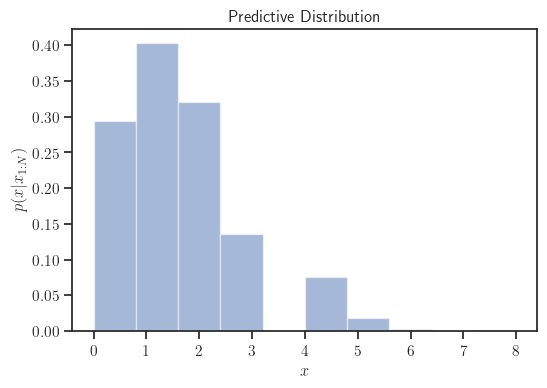

In [20]:
# defining the number of samples to draw and then drawing them
num_samples = 1000
samples = sample_posterior_predictive(num_samples, lambda_post)
# plotting samples in a normalized histogram
fig, ax = plt.subplots()
ax.hist(samples, alpha=0.5, density=True)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x|x_{1:N})$")
ax.set_title('Predictive Distribution')

H. What is the probability that at least one major earthquake will occur during the next decade?
<br>
*Hint: You may use a Monte Carlo estimate of the probability. Ignore the uncertainty in the estimate.*

In [21]:
# defining the number of samples to draw and then drawing them
num_samples = 10000
samples = sample_posterior_predictive(num_samples, lambda_post)

# Count how many major earthquakes occured:
count = 0
for i in range(num_samples):
    if samples[i] >=1:
        count += 1

prob_of_major_eq = count / num_samples # perform estimate

print(f"p(X >= 1 | data) = {prob_of_major_eq}")

p(X >= 1 | data) = 0.7604


I. Find a 95\% credible interval for $\lambda$.

Lambda is in [0.92, 2.28] with 95% probability


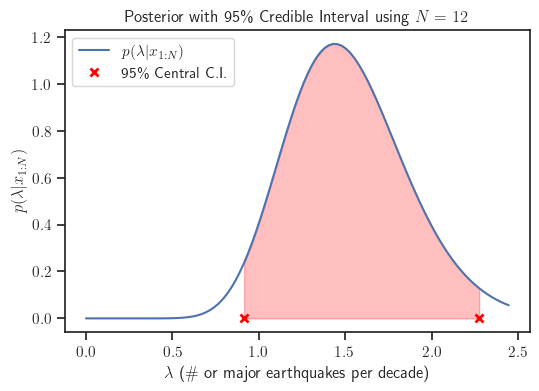

In [22]:
# calculate credible interval and display it
lambda_low = lambda_post.ppf(0.025)
lambda_up = lambda_post.ppf(0.975)
print(f'Lambda is in [{lambda_low:.2f}, {lambda_up:1.2f}] with 95% probability')

# plotting the credible interval with the posterior
fig, ax = plt.subplots()
ax.plot(lambdas_post, lambda_post.pdf(lambdas_post), label='$p(\lambda|x_{1:N})$')

lambdas_int = np.linspace(lambda_low, lambda_up, 100)
ax.fill_between(
    lambdas_int,
    np.zeros(lambdas_int.shape),
    lambda_post.pdf(lambdas_int),
    color='red',
    alpha=0.25
)
ax.plot(
    [lambda_low, lambda_up],
    np.zeros((2,)),
    'x',
    color='red',
    markeredgewidth=2,
    label='95\% Central C.I.'
)

ax.set_xlabel('$\lambda$ (\# or major earthquakes per decade)')
ax.set_ylabel('$p(\lambda|x_{1:N})$')
ax.set_title(f'Posterior with 95\% Credible Interval using $N = {len(eq_data)}$')
plt.legend(loc="best")

J. Find the $\lambda$ that minimizes the absolute loss (see lecture), call it $\lambda^*_N$.
Then, plot the fully Bayesian predictive $p(x|x_{1:N})$ in the same figure as $p(x|\lambda^*_N)$.

lambda_N* = 1.49


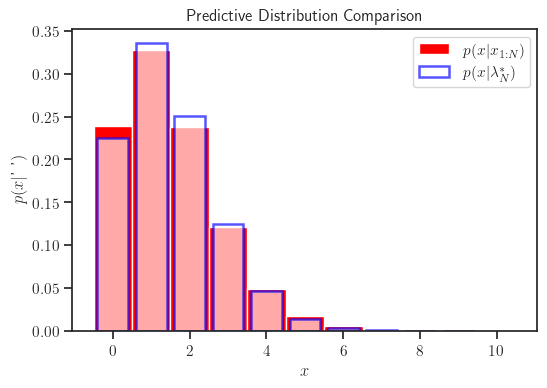

In [23]:
# calculate the choice for lambda that minimizes the absolute loss
lambda_N_star = lambda_post.median()
print(f"lambda_N* = {lambda_N_star:.2f}")
# generate a new Poisson random variable from this new lambda
X_minAbsoluteLoss = st.poisson(lambda_N_star)

# plotting the result
xs = range(0, 10)
fig, ax = plt.subplots()
ax.hist(samples, alpha=1.0, color='red', density=True,
        bins = [0,1,2,3,4,5,6,7,8,9,10,11], align='left', label=r"$p(x|x_{1:N})$")
ax.bar(xs, X_minAbsoluteLoss.pmf(xs), alpha=2/3, color='white', edgecolor='blue',
       linewidth='1.8', label=r"$p(x|\lambda^*_N)$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x|$" + "'   '" + r"$)$")
ax.set_title('Predictive Distribution Comparison')
plt.legend(loc="best")

L. Draw replicated data from the model and compare them to the observed data.
<br>
Hint: Complete the missing code at the places indicated below.

In [24]:
def replicate_experiment(post_rv, n=len(eq_data), n_rep=9):
    """Replicate the experiment.
    
    Arguments
    post_rv -- The random variable object corresponding to
               the posterior from which to sample.
    n       -- The number of observations.
    nrep    -- The number of repetitions.
    
    Returns:
    A numpy array of size n_rep x n.
    """
    x_rep = np.empty((n_rep, n), dtype="i")
    for i in range(n_rep):
        # sample from posterior, then sample from Poisson n times given posterior sample
        x_rep[i, :] = st.poisson(post_rv.rvs()).rvs(size=n)
    return x_rep

Try your code here:

In [25]:
n_rep = 9
x_rep = replicate_experiment(lambda_post, n_rep=n_rep)
# print(x_rep)

If it works, then try the following visualization:

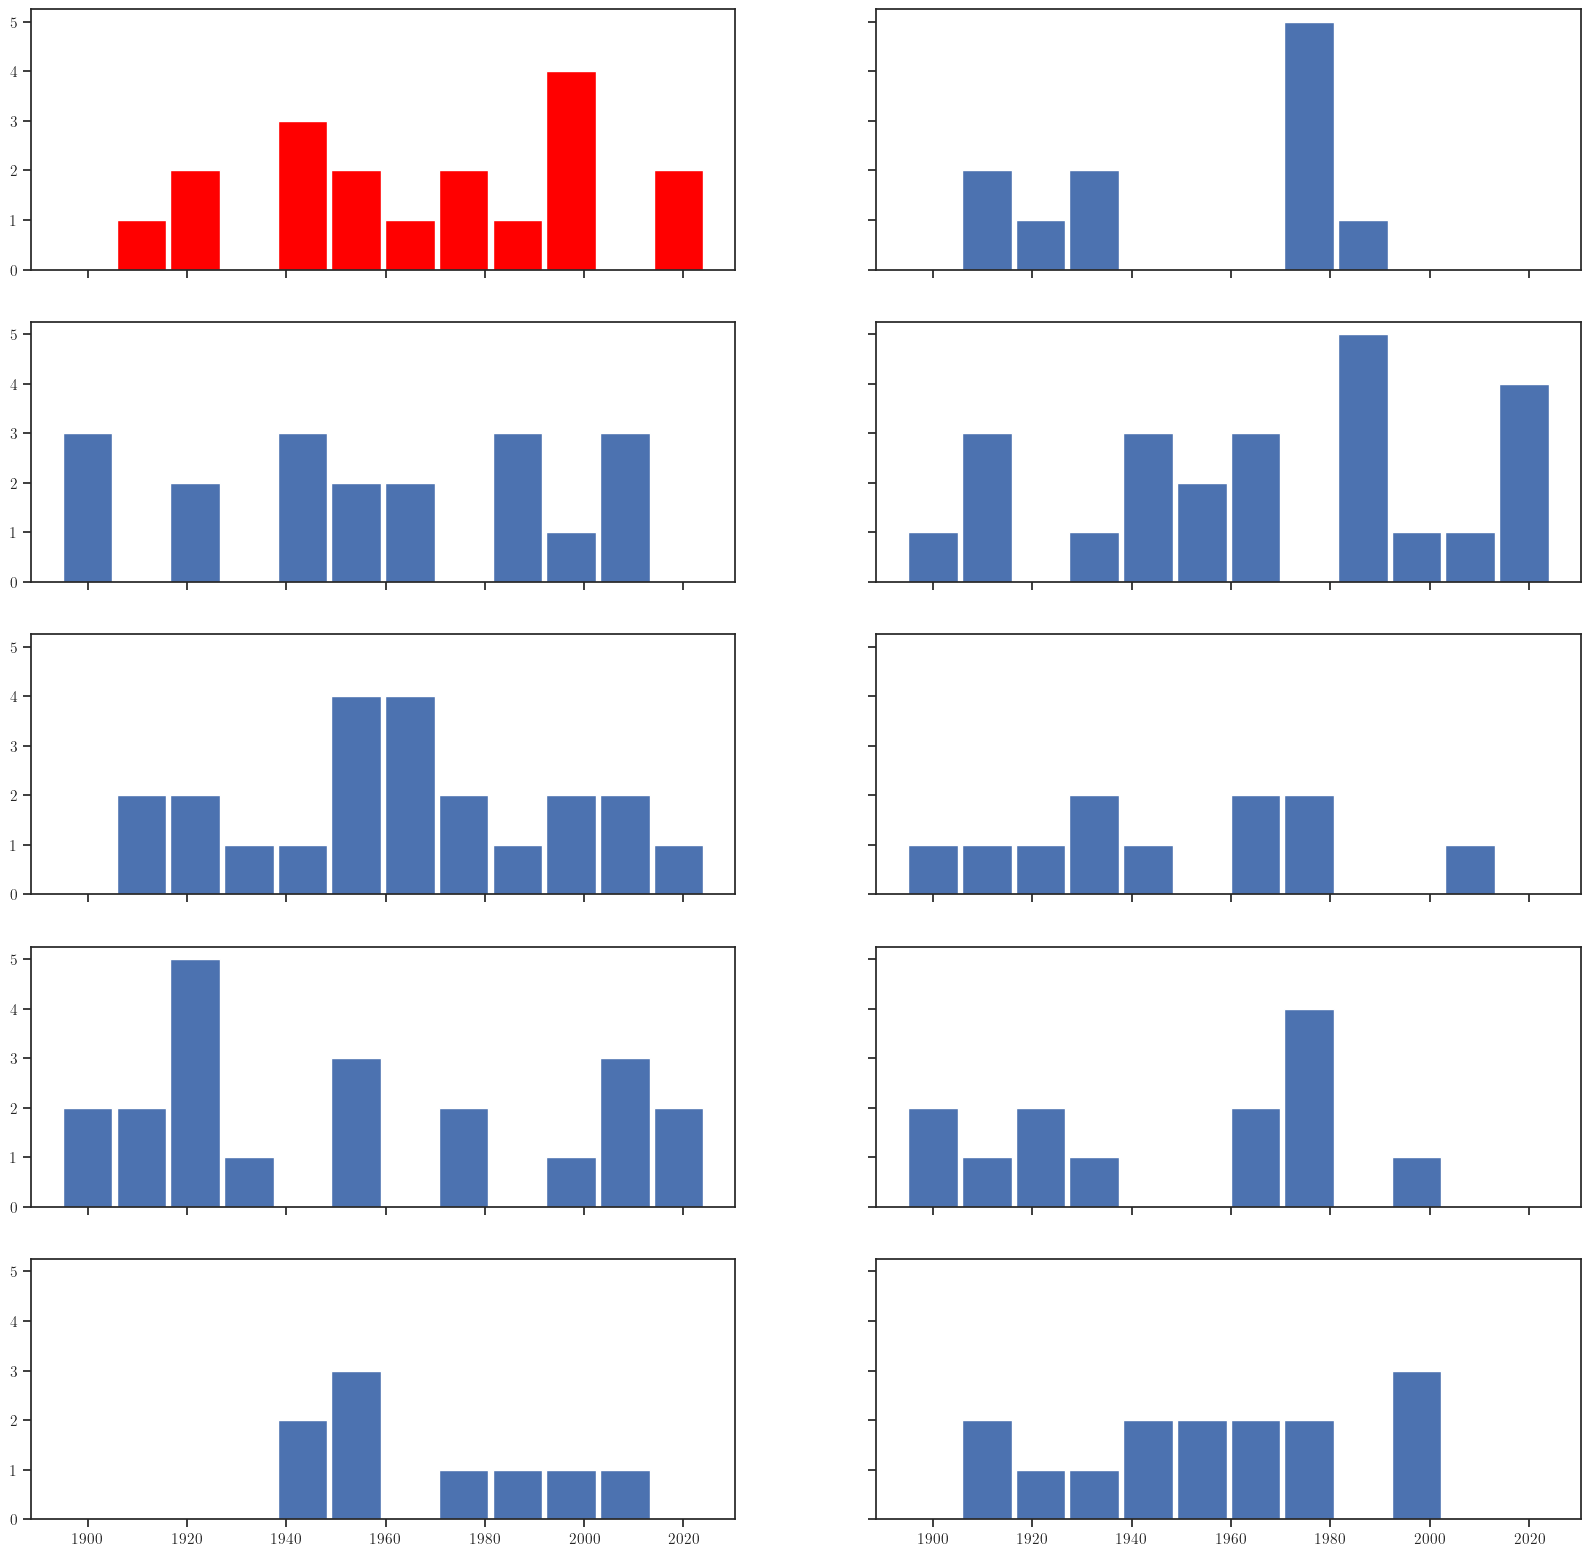

In [26]:
fig, ax = plt.subplots(
    5,
    2,
    sharex='all',
    sharey='all',
    figsize=(20, 20)
)
ax[0, 0].bar(
    np.linspace(1900, 2019, eq_data.shape[0]),
    eq_data,
    width=10,
    color='red'
)
for i in range(1, n_rep + 1):
    ax[int(i / 2), i % 2].bar(
        np.linspace(1900, 2019, eq_data.shape[0]),
        x_rep[i-1],
        width=10
    )

M. Plot the histograms and calculate the Bayesian p-values of the following test-quantities:

+ Maximum number of consecutive decades with no earthquakes.
+ Maximum number of consecutive decades with earthquakes.

*Hint: You may reuse the code from the textbook.*

In [27]:
def perform_diagnostics(post_rv, data, test_func, n_rep=1000):
    """Calculate Bayesian p-values.
    
    Arguments
    post_rv   -- The random variable object corresponding to
                 the posterior from which to sample.
    data      -- The training data.
    test_func -- The test function.
    n         -- The number of observations.
    nrep      -- The number of repetitions.
    
    Returns a dictionary that includes the observed value of
    the test function (T_obs), the Bayesian p-value (p_val),
    the replicated test statistic (T_rep),
    and all the replicated data (data_rep).
    """
    T_obs = test_func(data)
    n = data.shape[0]
    data_rep = replicate_experiment(post_rv, n_rep=n_rep)
    T_rep = np.array(
        tuple(
            test_func(x)
            for x in data_rep
        )
    )
    p_val = (
        np.sum(np.ones((n_rep,))[T_rep > T_obs]) / n_rep
    )
    return dict(
        T_obs=T_obs,
        p_val=p_val,
        T_rep=T_rep,
        data_rep=data_rep
    )


def plot_diagnostics(diagnostics):
    """Make the diagnostics plot.
    
    Arguments:
    diagnostics -- The dictionary returned by perform_diagnostics()
    """
    fig, ax = plt.subplots()
    tmp = ax.hist(
        diagnostics["T_rep"],
        density=True,
        alpha=0.25,
        label='Replicated test quantity'
    )[0]
    ax.plot(
        diagnostics["T_obs"] * np.ones((50,)),
        np.linspace(0, tmp.max(), 50),
        'k',
        label='Observed test quantity'
    )
    plt.legend(loc='best');
    

def do_diagnostics(post_rv, data, test_func, n_rep=1000):
    """Calculate Bayesian p-values and make the corresponding
    diagnostic plot.
    
    Arguments
    post_rv   -- The random variable object corresponding to
                 the posterior from which to sample.
    data      -- The training data.
    test_func -- The test function.
    n         -- The number of observations.
    nrep      -- The number of repetitions.
    
    Returns a dictionary that includes the observed value of
    the test function (T_obs), the Bayesian p-value (p_val),
    and the replicated experiment (data_rep).
    """
    res = perform_diagnostics(
        post_rv,
        data,
        test_func,
        n_rep=n_rep
    )

    T_obs = res["T_obs"]
    p_val = res["p_val"]

    print(f'The observed test quantity is {T_obs}')
    print(f'The Bayesian p_value is {p_val:.4f}')
    
    plot_diagnostics(res)

The observed test quantity is 1
The Bayesian p_value is 0.4240


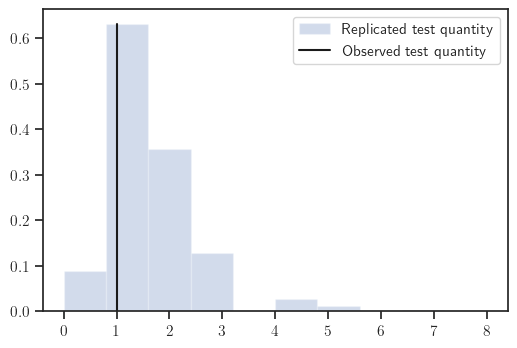

In [28]:
# Here is the first test function for you
def T_eq_max_neq(x):
    """Return the maximum number of consecutive decades
    with no earthquakes."""
    count = 0   # variable that stores the current count
    result = 0  # variable that stores the largest count
    for i in range(x.shape[0]):
        if x[i] != 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result
    
# function call to do_diagnostics() with first test function
do_diagnostics(
    lambda_post,
    eq_data,
    T_eq_max_neq
)

The observed test quantity is 6
The Bayesian p_value is 0.3680


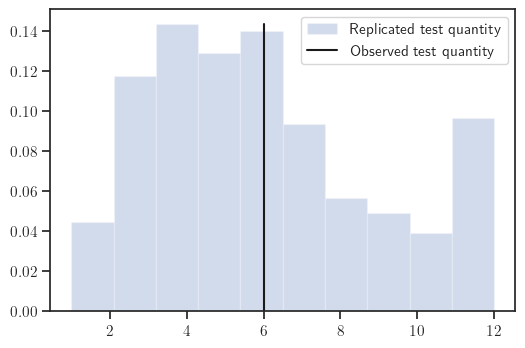

In [29]:
# function for the second test function (modified from the first)
def T_eq_max_weq(x):
    """Return the maximum number of consecutive decades
    with earthquakes."""
    count = 0   # variable that stores the current count
    result = 0  # variable that stores the largest count
    for i in range(x.shape[0]):
        if x[i] == 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result

# function call to do_diagnostics() with second test function
do_diagnostics(
    lambda_post,
    eq_data,
    T_eq_max_weq
)